### This notebook checks the QE curves as they are in obs_lsst_data repo

In [1]:
# make sure this is w_2019_49 or later
! eups list | grep lsst_distrib 

lsst_distrib          20.0.0+7   	current w_2020_27 setup


In [12]:
import matplotlib.pyplot as plt
from lsst.daf.persistence import Butler, NoResults
import os, numpy
import pandas as pd
from astropy import units as u
from scipy.interpolate import interp1d
import numpy as np

In [3]:
import lsst.syseng.throughputs as st
from lsst.geom import Point2D, Point2I
from lsst.afw.cameraGeom import FIELD_ANGLE, PIXELS
from lsst.obs.lsst.lsstCamMapper import LsstCamMapper

In [4]:
#DATADIR = f"{os.environ['OBS_LSST_DIR']}/ts8/CALIB"
DATADIR = f"{os.environ['OBS_LSST_DIR']}/lsstcam/CALIB" #we can use this after DM-22605 gets merged
print(DATADIR)
butler = Butler(DATADIR)
cam = butler.get('camera')

/home/bxin/lsst_stack/obs_lsst/lsstcam/CALIB


### Retrieve the vendor design curve (e2v or ITL)

In [7]:
defaultDirs = st.setDefaultDirs()
addLosses = False 
detectorE2V = st.buildDetector(defaultDirs['detector']+'/../e2v', addLosses)
detectorITL = st.buildDetector(defaultDirs['detector']+'/../itl', addLosses)

In [74]:
#includeProcC = True
includeProcC = False #default is false, because we know if measured those rafts fully, we should get them more like the others
procCList = ('R32', 'R03', 'R11', 'R21')

In [75]:
qeE2V = []
qeITL = []
for det in cam:
    rname, dname = det.getName().split('_')
    if (not includeProcC) and (rname in procCList):
        continue
    vendor = det.getSerial()[:3].lower()
    if vendor == 'e2v':
        sb0 = detectorE2V.sb
        wl0 = detectorE2V.wavelen
    elif vendor == 'itl':
        sb0 = detectorITL.sb
        wl0 = detectorITL.wavelen        

    # for interpolating proctol C data (see comp_QE_curve.ipynb for more details)
    idx = np.where(sb0>0.01)
    idx1=idx[0][0]-1
    idx2=idx[0][-1]+1

    x1 = wl0[idx1]
    y1 = sb0[idx1]
    x2 = wl0[idx2]
    y2 = sb0[idx2]
    
    try:
        #qe_curve = butler.get('qe_curve', raftName=rtmname, detectorName=dname, taiObs='2000-01-01T00:00:00')
        #qe_curve = butler.get('qe_curve', raftName=rname, detectorName=dname, taiObs='2000-01-01T00:00:00') #DM-22605 gets merged
        qe_curve = butler.get('qe_curve', raftName=rname, detectorName=dname, calibDate='1970-01-01T00:00:00') 
    except NoResults:
        print('No results found for this detector', det.getName())
        continue  # 
    for k in qe_curve.data:
        if len(qe_curve.data[k][0])>10:
            wlen = qe_curve.data[k][0]
            eff = qe_curve.data[k][1]
            f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='quadratic')
        else:
            aa = np.append(x1, qe_curve.data[k][0].value)
            aa = np.append(aa, x2)
            wlen = aa * qe_curve.data[k][0].unit

            aa = np.append(y1, qe_curve.data[k][1].value)
            aa = np.append(aa, y2)
            eff = aa * qe_curve.data[k][1].unit
            f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='slinear')#quadratic causes overshoot
        sb = f(wl0)*0.01
        #alternatively we could do (only for >10 QE measurements)
        #amp_point = amp.getBBox().getCenter()
        #sb = qe_curve.evaluate(det, amp_point, wavelen* u.nm, kind='quadratic').value*.01 #unit was percent in CALIB data
            
        sb[np.isnan(sb)] = 0
        if np.max(sb)>1.5:
            print('These seem too LARGE ', k)
            print(np.max(sb))
            sb = 0
        if np.max(sb)<0.2: #3 dead channels, 1 out of each of R01, R10, and R30; see camera confluence page table
            print('dead channel: %s %s, max sb = %.2f'%(det.getName(), k, np.max(sb)))
            continue;
        if vendor == 'e2v':
            qeE2V.append(sb)
        elif vendor == 'itl':
            qeITL.append(sb)

dead channel: R01_S01 C00, max sb = 0.11
dead channel: R10_S00 C00, max sb = 0.00
dead channel: R30_S00 C10, max sb = 0.00
No results found for this detector R00_SG0
No results found for this detector R00_SG1
No results found for this detector R00_SW0
No results found for this detector R00_SW1
No results found for this detector R04_SG0
No results found for this detector R04_SG1
No results found for this detector R04_SW0
No results found for this detector R04_SW1
No results found for this detector R40_SG0
No results found for this detector R40_SG1
No results found for this detector R40_SW0
No results found for this detector R40_SW1
No results found for this detector R44_SG0
No results found for this detector R44_SG1
No results found for this detector R44_SW0
No results found for this detector R44_SW1


In [76]:
qeITL = np.array(qeITL)
qeE2V = np.array(qeE2V)
qeITL[qeITL==0] = np.nan
qeE2V[qeE2V==0] = np.nan

In [77]:
print(qeITL.shape, qeE2V.shape, qeITL.shape[0]+qeE2V.shape[0], 16*9*21, 16*9*(21-4))

(1006, 8501) (1439, 8501) 2445 3024 2448


In [78]:
itlmean = np.mean(qeITL, axis=0)
itlstd = np.std(qeITL, axis=0)
e2vmean = np.mean(qeE2V, axis=0)
e2vstd = np.std(qeE2V, axis=0)

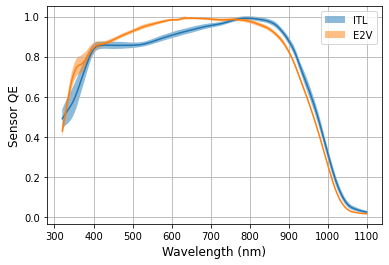

In [79]:
fig, ax = plt.subplots()
plt.plot(wl0, itlmean)
plt.fill_between(wl0, itlmean-itlstd, itlmean+itlstd, alpha=0.5, label='ITL')
plt.plot(wl0, e2vmean)
plt.fill_between(wl0, e2vmean-e2vstd, e2vmean+e2vstd, alpha=0.5, label='E2V')
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Sensor QE', fontsize=12)
plt.grid()
plt.savefig('dm_plots/sum_QE.pdf')
#plt.savefig('dm_plots/sum_QE_21rafts.pdf')